<a href="https://colab.research.google.com/github/Joefamouze/Machine_learning/blob/master/vector_databases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from scipy.stats import norm

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
x_train, x_test = x_train.astype('float32')/255., x_test.astype('float32')/255.
x_train_flat, x_test_flat = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)

In [8]:
# Neural Network Parameters
batch_size, n_epoch = 100, 50
n_hidden, z_dim = 256, 2

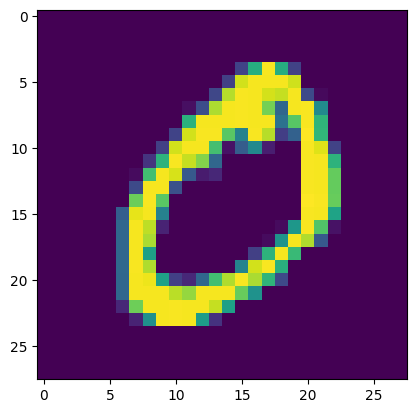

In [9]:
plt.imshow(x_train[1])

In [10]:
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

In [12]:
# Encoder - from 784->256->128->2
inputs_flat = Input(shape=(x_train_flat.shape[1:]))
x_flat = Dense(n_hidden, activation='relu')(inputs_flat) # first hidden layer
x_flat = Dense(n_hidden//2, activation='relu')(x_flat)  # second hidden layer

# hidden state, which we will pass into the Model to get the Encoder.
mu_flat = Dense(z_dim)(x_flat)
log_var_flat = Dense(z_dim)(x_flat)
z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])

In [13]:
#Decoder - from 2->128->256->784
latent_inputs = Input(shape=(z_dim,))
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_train_flat.shape[1], activation='sigmoid')
z_decoded = z_decoder1(latent_inputs)
z_decoded = z_decoder2(z_decoded)
y_decoded = y_decoder(z_decoded)
decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")

outputs_flat = decoder_flat(z_flat)

In [14]:
# variational autoencoder (VAE) - to reconstruction input
reconstruction_loss = losses.binary_crossentropy(inputs_flat,
                                                 outputs_flat) * x_train_flat.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu_flat) + K.exp(log_var_flat) - log_var_flat - 1, axis = -1)
vae_flat_loss = reconstruction_loss + kl_loss

# Build model
#  Ensure that the reconstructed outputs are as close to the inputs
vae_flat = Model(inputs_flat, outputs_flat)
vae_flat.add_loss(vae_flat_loss)
vae_flat.compile(optimizer='adam')

In [16]:
# train
vae_flat.fit(
    x_train_flat,
    shuffle=True,
    epochs=n_epoch,
    batch_size=batch_size,
    validation_data=(x_test_flat, None),
    verbose=1
)

Epoch 1/50
600/600 [==============================] - 10s 14ms/step - loss: 191.3645 - val_loss: 167.4349
Epoch 2/50
600/600 [==============================] - 10s 16ms/step - loss: 163.3967 - val_loss: 159.7204
Epoch 3/50
600/600 [==============================] - 9s 16ms/step - loss: 157.9884 - val_loss: 156.1156
Epoch 4/50
600/600 [==============================] - 8s 14ms/step - loss: 154.9443 - val_loss: 154.4430
Epoch 5/50
600/600 [==============================] - 10s 16ms/step - loss: 152.9631 - val_loss: 152.1608
Epoch 6/50
600/600 [==============================] - 8s 13ms/step - loss: 151.3636 - val_loss: 151.1738
Epoch 7/50
600/600 [==============================] - 10s 16ms/step - loss: 149.9405 - val_loss: 149.7612
Epoch 8/50
600/600 [==============================] - 9s 16ms/step - loss: 148.5332 - val_loss: 148.2358
Epoch 9/50
600/600 [==============================] - 9s 16ms/step - loss: 147.5226 - val_loss: 147.6606
Epoch 10/50
600/600 [==============================

In [17]:
# Build encoders
encoder_f = Model(inputs_flat, z_flat)



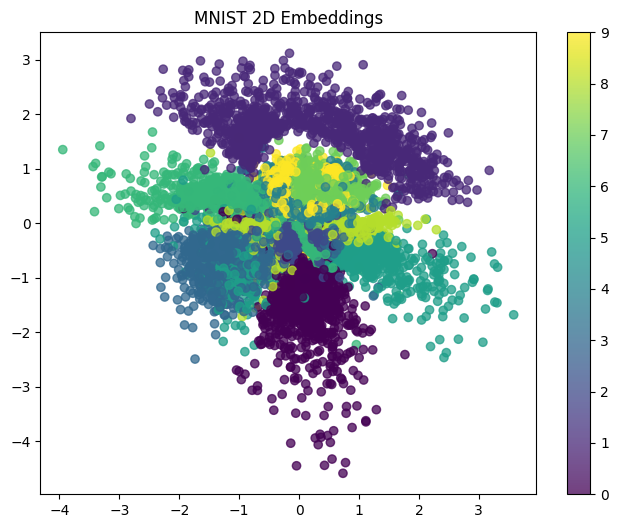

In [18]:
x_te_latent = encoder_f.predict(x_test_flat, batch_size=batch_size,verbose=0)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_test, alpha=0.75)
plt.title('MNIST 2D Embeddings')
plt.colorbar()
plt.show()

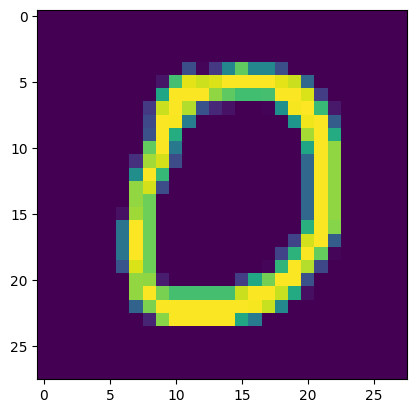

In [19]:
plt.imshow(x_test_flat[10].reshape(28,28))

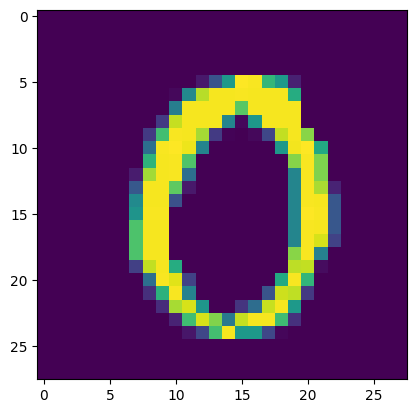

In [27]:

plt.imshow(x_test_flat[13].reshape(28,28))

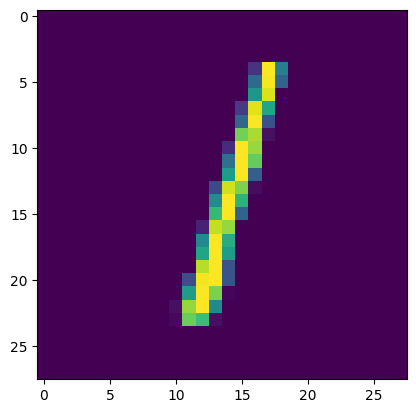

In [28]:
plt.imshow(x_test_flat[2].reshape(28,28))

In [26]:
# calculate vectors for each digit
zero_A = x_te_latent[10]
zero_B = x_te_latent[13]
one = x_te_latent[2]

print(f"Embedding for the first ZERO is  {zero_A}")
print(f"Embedding for the second ZERO is {zero_B}")
print(f"Embedding for the ONE is         {one}")

Embedding for the first ZERO is  [-0.08440687 -1.3409106 ]
Embedding for the second ZERO is [-0.01414154 -1.068325  ]
Embedding for the ONE is         [0.80812025 2.2877095 ]


In [ ]:
!pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [32]:
#Sentences we want to encode. Example:
sentence = ['The team enjoyed the hike through the meadow',
            'The national park had great views',
            'Olive oil drizzled over pizza tastes delicious',
            'Today is a good day for hiking']

#Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)

#Preview the embeddings
print(embedding)

[[ 0.37061962  0.26414254  0.21265666 ...  0.14994545 -0.2579493
  -0.23970738]
 [ 0.6693329   0.40094966 -0.48208427 ...  0.10645877 -1.5067161
  -0.01547367]
 [-0.26555902  0.11172411 -0.14733048 ...  0.4219747   0.883946
   0.10763925]
 [-0.26768422 -0.07105551  0.592067   ... -0.2872999  -0.9680214
   0.2097582 ]]


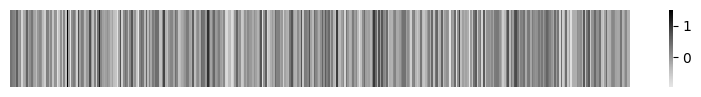

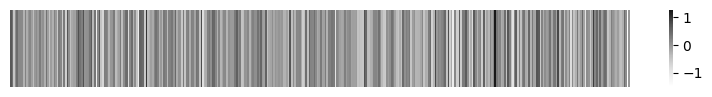

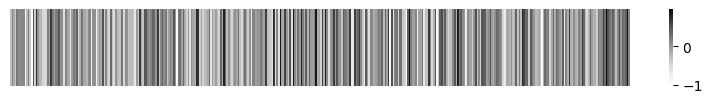

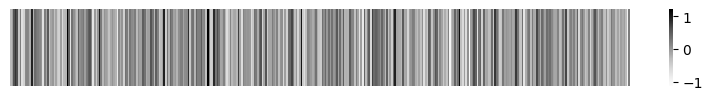

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(embedding[0].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[1].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[2].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[3].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

In [38]:
#Euclidean distance
np.linalg.norm((zero_A - zero_B), ord=2)

0.28149614

In [39]:

#Calculate L2 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=2))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=2))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=2))

Distance zeroA-zeroB: 0.28149614
Distance zeroA-one:   3.7367754
Distance zeroB-one:   3.4552977
